In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as func
from pyspark.sql import Window
from pyspark.sql.types import *

In [2]:
sc = SparkContext(appName="analysis")
spark = SparkSession(sc)

In [3]:
df = spark.read.csv("./analysis_input/", header=True, inferSchema=True)
df.show(10)

+------+-----+----+----------+------------+--------+--------------+----------------+----+------------------+--------------------+------------------+
|app_id|index|year|popularity|review_score|discount|historical_low|sale_price_scale|days|sale_increase_rate|normal_increase_rate|            effect|
+------+-----+----+----------+------------+--------+--------------+----------------+----+------------------+--------------------+------------------+
|   300|    1|2015|      4394|           8|      75|             1|               0|  11|10.454545454545455|  3.6025641025641026| 6.851981351981353|
|   300|    2|2015|      5071|           8|      75|             0|               0|   6|               7.5|   4.857142857142857|2.6428571428571432|
|   300|    3|2015|      5218|           8|      75|             0|               0|  13|13.307692307692308|               5.375| 7.932692307692308|
|   300|    4|2016|      5563|           8|      75|             0|               0|   7| 8.71428571428571

In [4]:
df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- review_score: integer (nullable = true)
 |-- discount: integer (nullable = true)
 |-- historical_low: integer (nullable = true)
 |-- sale_price_scale: integer (nullable = true)
 |-- days: integer (nullable = true)
 |-- sale_increase_rate: double (nullable = true)
 |-- normal_increase_rate: double (nullable = true)
 |-- effect: double (nullable = true)



In [5]:
df_pd = df.toPandas()

In [6]:
not_include = ['app_id', 'sale_increase_rate', 'normal_increase_rate', 'effect']
covariates = [x for x in df_pd.columns.to_list() if x not in not_include]
covariates

['index',
 'year',
 'popularity',
 'review_score',
 'discount',
 'historical_low',
 'sale_price_scale',
 'days']

d:\Application\Anaconda3\envs\steam\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


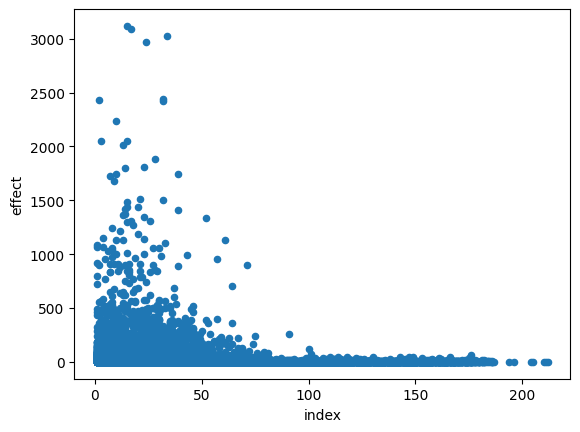

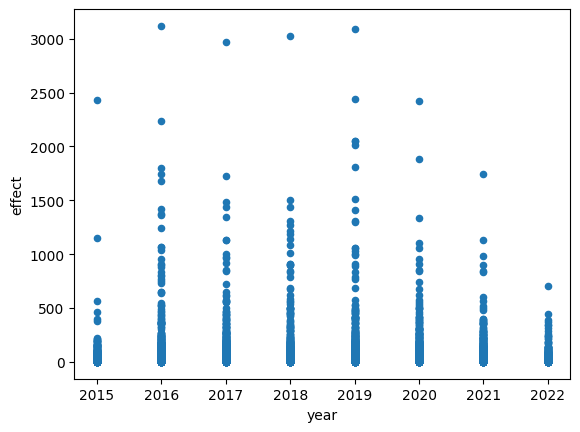

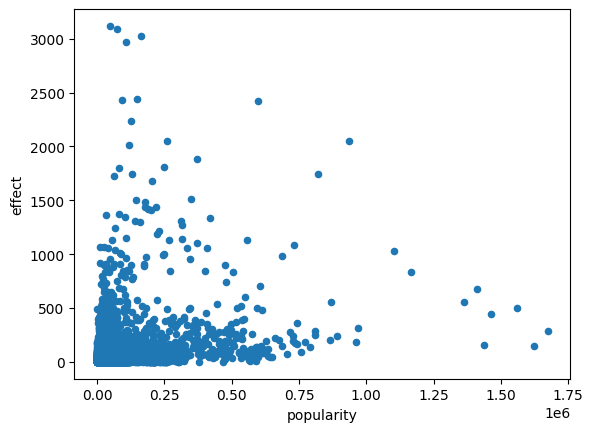

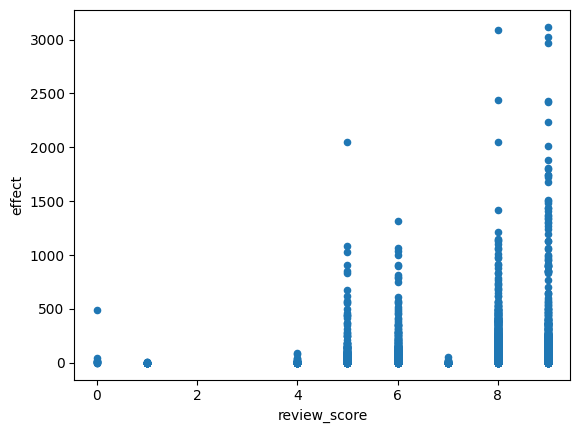

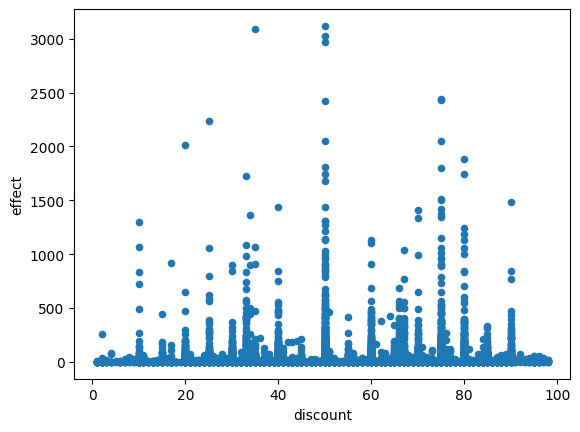

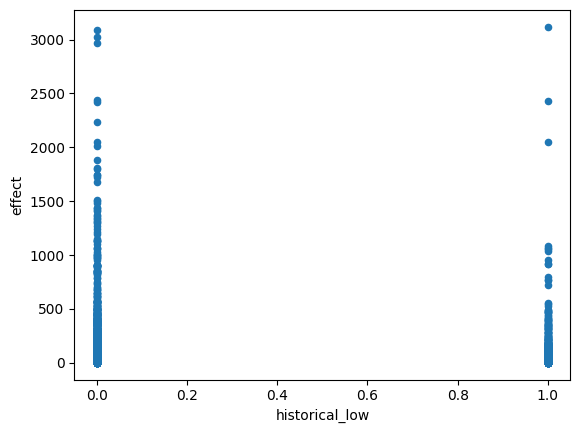

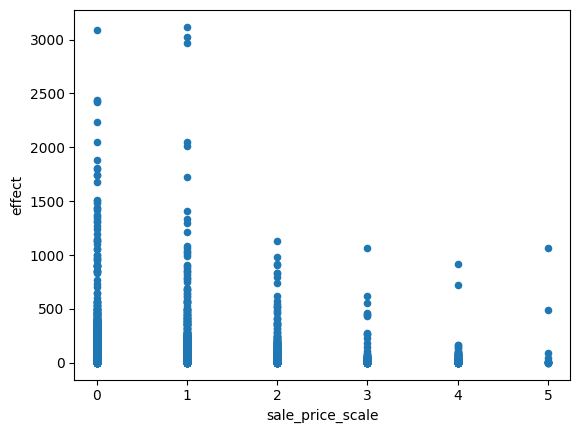

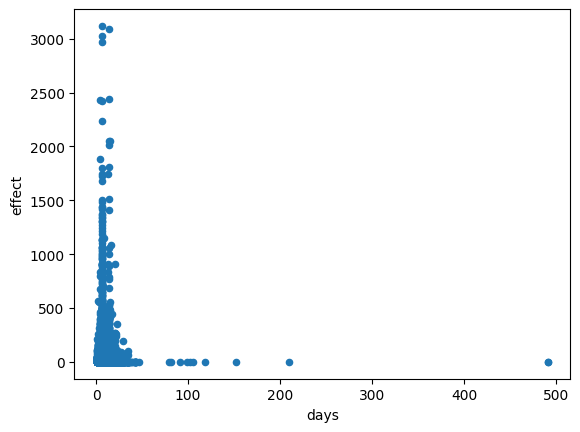

In [7]:
for x in covariates:
    df_pd.plot.scatter(x=x, y='effect')

In [8]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

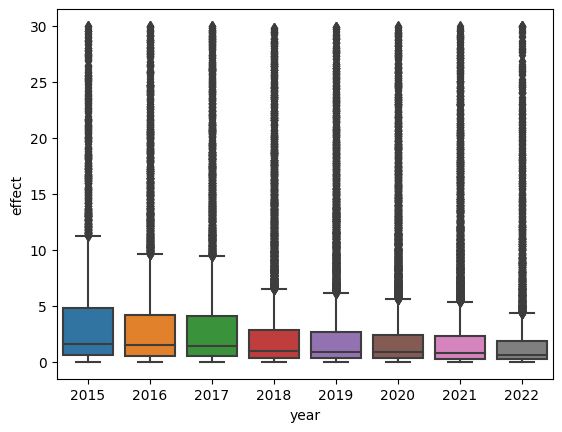

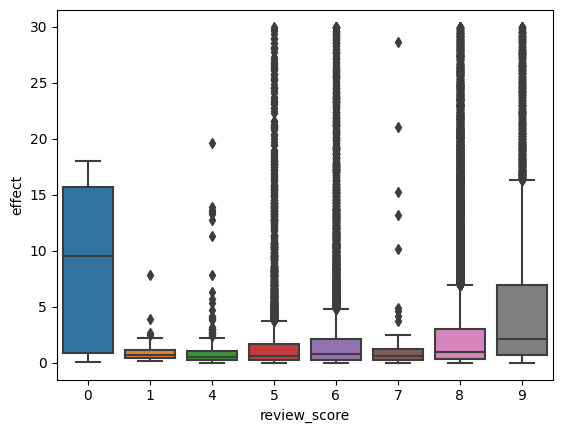

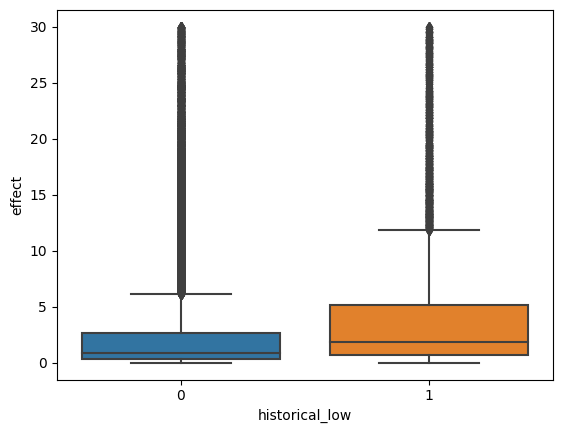

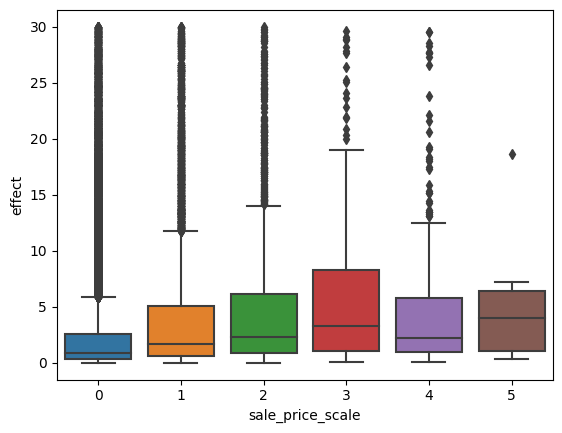

In [10]:
temp_df = df_pd[df_pd['effect'] < 30]
category = ['year', 'review_score', 'historical_low', 'sale_price_scale']
for x in category:
    sns.boxplot(data=temp_df, x=x, y='effect')
    plt.show()

In [21]:
from pyspark.ml.feature import VectorAssembler, StandardScaler


# featureCols = ['index', 'year', 'popularity', 'review_score', 'discount', 'historical_low', 'sale_price_scale', 'days']
featureCols = ['index', 'popularity', 'review_score', 'discount', 'historical_low', 'sale_price_scale']
final_df = df.select(featureCols + ['effect'])
final_df.show(5)

+-----+----------+------------+--------+--------------+----------------+------------------+
|index|popularity|review_score|discount|historical_low|sale_price_scale|            effect|
+-----+----------+------------+--------+--------------+----------------+------------------+
|    1|      4394|           8|      75|             1|               0| 6.851981351981353|
|    2|      5071|           8|      75|             0|               0|2.6428571428571432|
|    3|      5218|           8|      75|             0|               0| 7.932692307692308|
|    4|      5563|           8|      75|             0|               0| 4.873376623376623|
|    5|      6131|           8|      75|             0|               0| 4.543533930857874|
+-----+----------+------------+--------+--------------+----------------+------------------+
only showing top 5 rows



In [22]:
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
assembled_df = assembler.transform(final_df)
assembled_df.show(5)

+-----+----------+------------+--------+--------------+----------------+------------------+--------------------+
|index|popularity|review_score|discount|historical_low|sale_price_scale|            effect|            features|
+-----+----------+------------+--------+--------------+----------------+------------------+--------------------+
|    1|      4394|           8|      75|             1|               0| 6.851981351981353|[1.0,4394.0,8.0,7...|
|    2|      5071|           8|      75|             0|               0|2.6428571428571432|[2.0,5071.0,8.0,7...|
|    3|      5218|           8|      75|             0|               0| 7.932692307692308|[3.0,5218.0,8.0,7...|
|    4|      5563|           8|      75|             0|               0| 4.873376623376623|[4.0,5563.0,8.0,7...|
|    5|      6131|           8|      75|             0|               0| 4.543533930857874|[5.0,6131.0,8.0,7...|
+-----+----------+------------+--------+--------------+----------------+------------------+-----

In [23]:
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)
scaled_df.select("features", "features_scaled").show(10)

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[1.0,4394.0,8.0,7...|[0.04162354875152...|
|[2.0,5071.0,8.0,7...|[0.08324709750305...|
|[3.0,5218.0,8.0,7...|[0.12487064625457...|
|[4.0,5563.0,8.0,7...|[0.16649419500610...|
|[5.0,6131.0,8.0,7...|[0.20811774375763...|
|[6.0,6682.0,8.0,8...|[0.24974129250915...|
|[7.0,7003.0,8.0,8...|[0.29136484126068...|
|[8.0,7785.0,8.0,8...|[0.33298839001220...|
|[9.0,8502.0,8.0,9...|[0.37461193876373...|
|[10.0,8859.0,8.0,...|[0.41623548751526...|
+--------------------+--------------------+
only showing top 10 rows



In [25]:
train_data, test_data = scaled_df.randomSplit([.75,.25], seed=1339)

In [26]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = (LinearRegression(featuresCol='features_scaled', labelCol="effect", predictionCol='effect_pred',
                       maxIter=100, standardization=False))
linearModel = lr.fit(train_data)
predictions = linearModel.transform(test_data)

pred_and_labels = predictions.select("effect_pred", "effect")

In [27]:
evaluator = RegressionEvaluator(predictionCol='effect_pred', labelCol='effect', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

RMSE: 59.59857326574219


In [28]:
evaluator = RegressionEvaluator(predictionCol='effect_pred', labelCol='effect', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

MAE: 10.997144807065668


In [29]:
evaluator = RegressionEvaluator(predictionCol='effect_pred', labelCol='effect', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))

R2: 0.1341067592546844


In [30]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="effect", featuresCol="features", predictionCol='effect_pred')

# from pyspark.ml import Pipeline

# pipeline = Pipeline(stages=[assembler, rf])

# from pyspark.ml.tuning import ParamGridBuilder
# import numpy as np
# paramGrid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 2)]) \
#     .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 2)]) \
#     .build()

# from pyspark.ml.tuning import CrossValidator
# crossval = CrossValidator(estimator=pipeline,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=RegressionEvaluator(),
#                           numFolds=3)


rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)

In [31]:
pred_and_labels = predictions.select("effect_pred", "effect")

In [32]:
evaluator = RegressionEvaluator(predictionCol='effect_pred', labelCol='effect', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

RMSE: 57.95850293853786


In [33]:
evaluator = RegressionEvaluator(predictionCol='effect_pred', labelCol='effect', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

MAE: 10.141050651035245


In [34]:
evaluator = RegressionEvaluator(predictionCol='effect_pred', labelCol='effect', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))

R2: 0.1811074099280673


In [35]:
def find_outliers(df):

    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol, func.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [36]:
new_df = find_outliers(df)
new_df.show(10)

+------+-----+----+----------+------------+--------+--------------+----------------+----+------------------+--------------------+------------------+--------------+
|app_id|index|year|popularity|review_score|discount|historical_low|sale_price_scale|days|sale_increase_rate|normal_increase_rate|            effect|total_outliers|
+------+-----+----+----------+------------+--------+--------------+----------------+----+------------------+--------------------+------------------+--------------+
|   300|    1|2015|      4394|           8|      75|             1|               0|  11|10.454545454545455|  3.6025641025641026| 6.851981351981353|             1|
|   300|    2|2015|      5071|           8|      75|             0|               0|   6|               7.5|   4.857142857142857|2.6428571428571432|             0|
|   300|    3|2015|      5218|           8|      75|             0|               0|  13|13.307692307692308|               5.375| 7.932692307692308|             0|
|   300|    4|20

In [40]:
no_outliers_df = new_df.filter(new_df['total_Outliers']<=1)
no_outliers_df = no_outliers_df.select(*df.columns)

In [41]:
no_outliers_df.count()

67191

d:\Application\Anaconda3\envs\steam\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


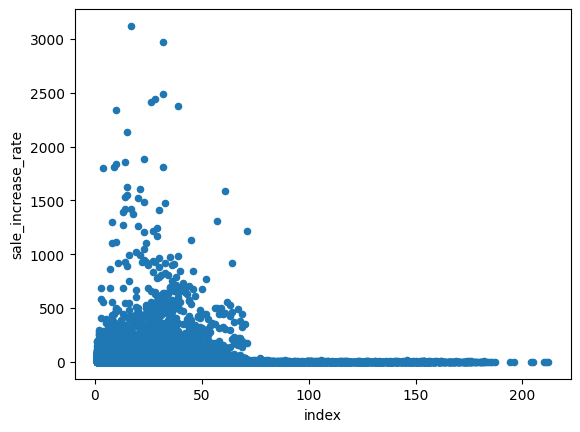

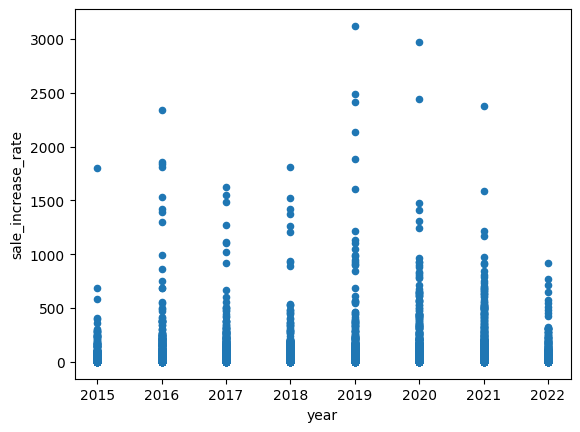

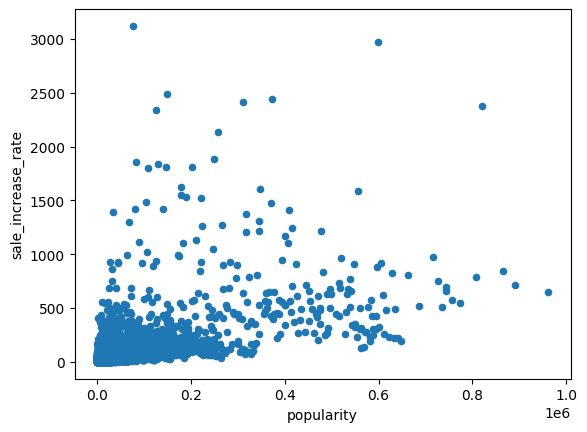

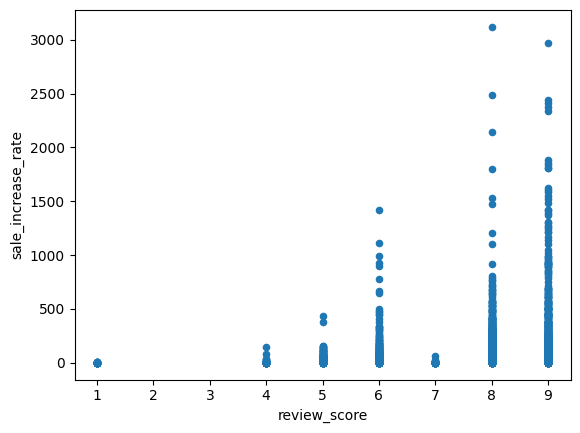

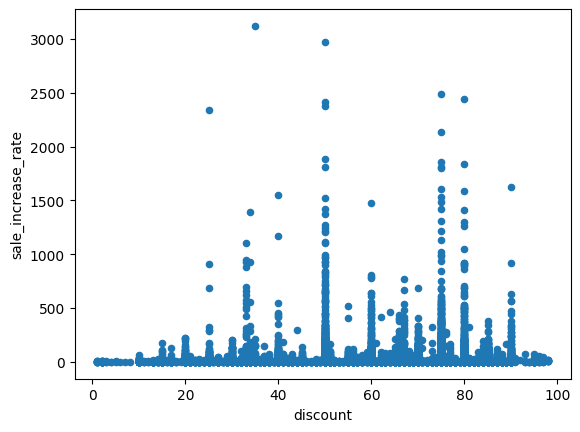

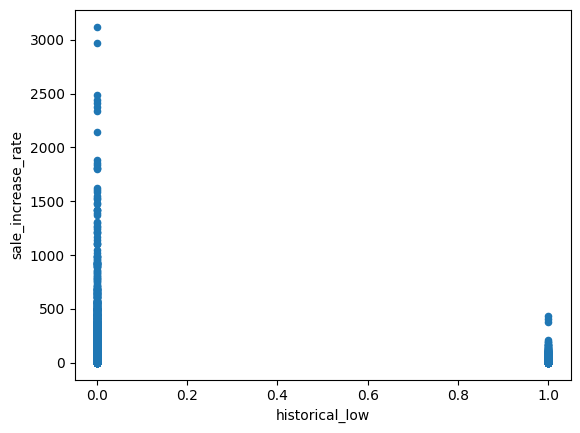

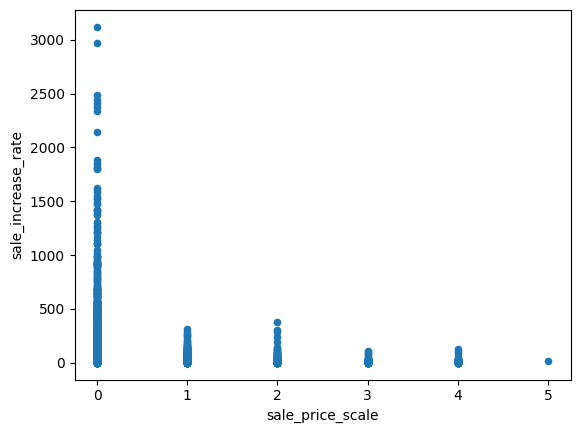

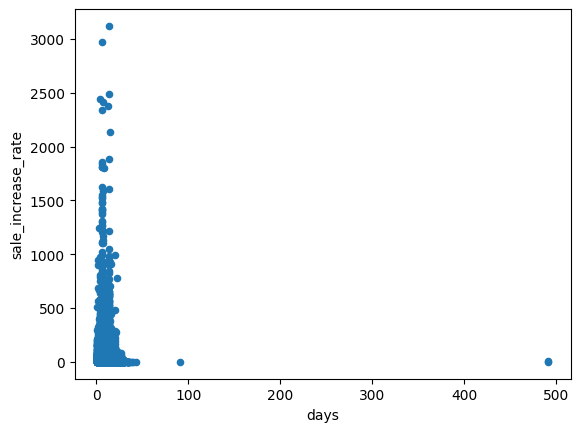

In [49]:
df_pd = no_outliers_df.toPandas()

not_include = ['app_id', 'sale_increase_rate', 'normal_increase_rate', 'effect']
covariates = [x for x in df_pd.columns.to_list() if x not in not_include]

for x in covariates:
    df_pd.plot.scatter(x=x, y='sale_increase_rate')

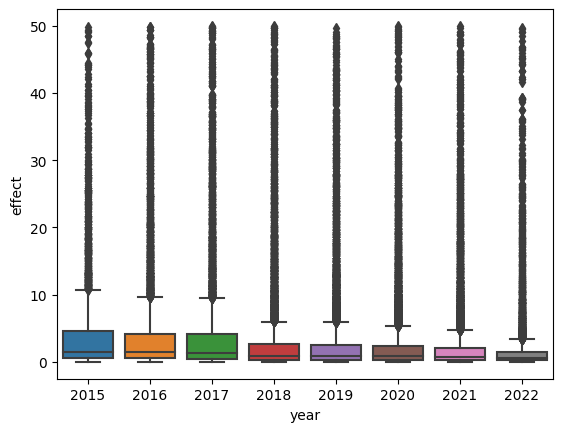

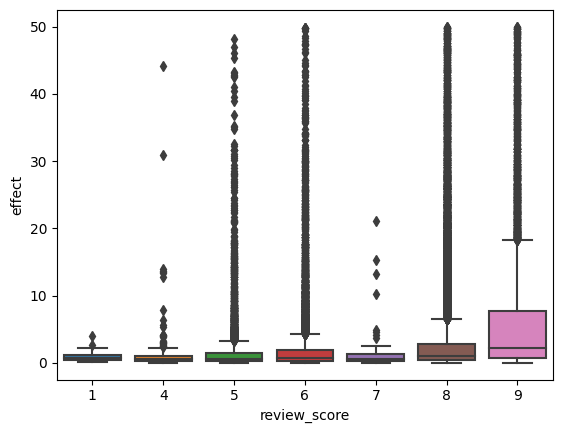

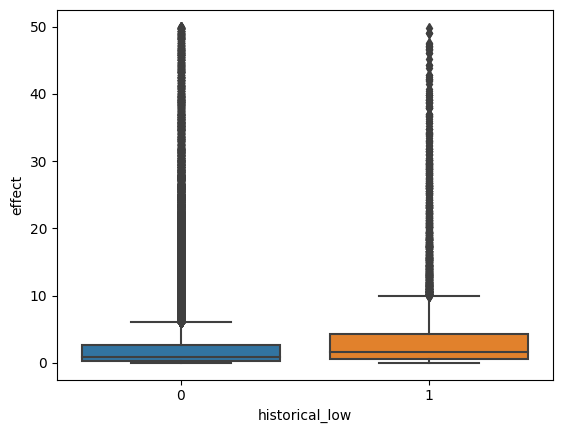

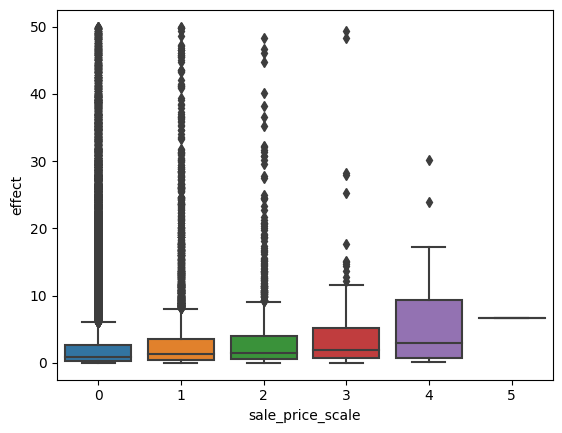

In [44]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

temp_df = df_pd[df_pd['effect'] < 50]
category = ['year', 'review_score', 'historical_low', 'sale_price_scale']
for x in category:
    sns.boxplot(data=temp_df, x=x, y='effect')
    plt.show()

In [75]:
from pyspark.ml.feature import VectorAssembler, StandardScaler


# featureCols = ['index', 'year', 'popularity', 'review_score', 'discount', 'historical_low', 'sale_price_scale', 'days']
featureCols = ['index', 'popularity', 'review_score', 'discount', 'historical_low', 'sale_price_scale', 'days']
final_df = no_outliers_df.select(featureCols + ['effect'])

final_df = final_df.where(final_df['effect'] < 1000)

assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
assembled_df = assembler.transform(final_df)
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

train_data, test_data = scaled_df.randomSplit([.75,.25], seed=1339)

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = (LinearRegression(featuresCol='features', labelCol="effect", predictionCol='effect_pred',
                       maxIter=100, standardization=False))
linearModel = lr.fit(train_data)
predictions = linearModel.transform(test_data)

pred_and_labels = predictions.select("effect_pred", "effect")

evaluator = RegressionEvaluator(predictionCol='effect_pred', labelCol='effect', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_pred', labelCol='effect', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_pred', labelCol='effect', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))


print("=============")
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="effect", featuresCol="features", predictionCol='effect_pred')

rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)

pred_and_labels = predictions.select("effect_pred", "effect")

evaluator = RegressionEvaluator(predictionCol='effect_pred', labelCol='effect', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_pred', labelCol='effect', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='effect_pred', labelCol='effect', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))

RMSE: 23.42624400750698
MAE: 6.196994334257427
R2: 0.18851952006260364
RMSE: 22.273271291625104
MAE: 5.546464896885405
R2: 0.266431344873164


In [76]:
from pyspark.ml.feature import VectorAssembler, StandardScaler


# featureCols = ['index', 'year', 'popularity', 'review_score', 'discount', 'historical_low', 'sale_price_scale', 'days']
featureCols = ['index', 'popularity', 'review_score', 'discount', 'historical_low', 'sale_price_scale', 'days']
final_df = no_outliers_df.select(featureCols + ['sale_increase_rate'])

# final_df = final_df.where(final_df['sale_increase_rate'] < 1500)

assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
assembled_df = assembler.transform(final_df)
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

train_data, test_data = scaled_df.randomSplit([.75,.25], seed=1339)

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = (LinearRegression(featuresCol='features', labelCol="sale_increase_rate", predictionCol='sale_increase_rate_pred',
                       maxIter=100, standardization=False))
linearModel = lr.fit(train_data)
predictions = linearModel.transform(test_data)

pred_and_labels = predictions.select("sale_increase_rate_pred", "sale_increase_rate")

evaluator = RegressionEvaluator(predictionCol='sale_increase_rate_pred', labelCol='sale_increase_rate', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='sale_increase_rate_pred', labelCol='sale_increase_rate', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='sale_increase_rate_pred', labelCol='sale_increase_rate', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))



print("=============")
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="sale_increase_rate", featuresCol="features", predictionCol='sale_increase_rate_pred')

rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)

pred_and_labels = predictions.select("sale_increase_rate_pred", "sale_increase_rate")

evaluator = RegressionEvaluator(predictionCol='sale_increase_rate_pred', labelCol='sale_increase_rate', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='sale_increase_rate_pred', labelCol='sale_increase_rate', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(pred_and_labels)))

evaluator = RegressionEvaluator(predictionCol='sale_increase_rate_pred', labelCol='sale_increase_rate', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(pred_and_labels)))

RMSE: 35.923212332838155
MAE: 8.841148018800581
R2: 0.45654634565533914
RMSE: 33.496346720979496
MAE: 8.738813642089838
R2: 0.5274942809759652
